## run.py Code Analysis

run.py 코드의 한줄 한줄을 분석해보는 주피터 노트북 파일

In [1]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision.transforms import ToTensor

import numpy as np

input_image = 'cat.jpg'

img = Image.open(input_image).convert('YCbCr')
y, cb, cr = img.split()

print('img shape:', np.array(img).shape)
print('y, cb, cr shape:', np.array(y).shape)

img shape: (224, 224, 3)
y, cb, cr shape: (224, 224)


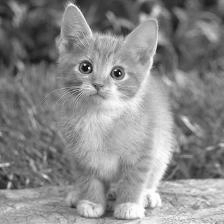

In [2]:
y

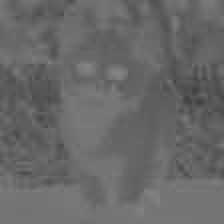

In [3]:
cb

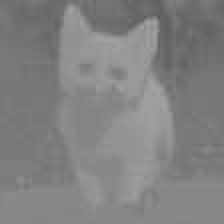

In [4]:
cr

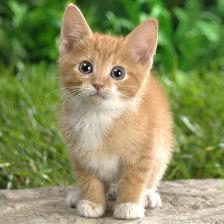

In [5]:
# y, cb, cr 채널을 분리하고 다시 합쳐서 RGB로 만드는 코드
# SR된 결과를 볼 때 활용할 것
# 원본과 똑같음

out_img = Image.merge('YCbCr', [y, cb, cr]).convert('RGB')
out_img

In [6]:
import torch.nn as nn

# f1 = 9, f2 = 1, f3 = 5, n1 = 64, n2 = 32
# 논문 p.11을 보면, "Y only" 실험에서는 c=1로, 
# 즉, 모델의 인풋 채널과 최종 아웃풋 채널 수가 1이어야 한다는 뜻

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size = 9, stride = 1, padding = 4),
                nn.ReLU())
        
        self.layer2 = nn.Sequential(
                nn.Conv2d(64, 32, kernel_size = 1, stride = 1, padding = 0),
                nn.ReLU())
        
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 1, kernel_size = 5, stride = 1, padding = 2))
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        return x

In [7]:
model = SRCNN() # 사용한 모델 정의하고
model.load_state_dict(torch.load('epoch_test.pth')) # 그에 따른 가중치 checkpoint 불러오기 (바꿀 수 있음)

img_to_tensor = ToTensor()
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]) # SR 알고리즘은 y채널에만 적용한다

print(input.shape)

torch.Size([1, 1, 224, 224])


In [8]:
out = model(input)
out

tensor([[[[0.1401, 0.1725, 0.1949,  ..., 0.4515, 0.4121, 0.3098],
          [0.1628, 0.2038, 0.2071,  ..., 0.5640, 0.5551, 0.4386],
          [0.1794, 0.2115, 0.1955,  ..., 0.5780, 0.6132, 0.5076],
          ...,
          [0.5699, 0.6405, 0.6134,  ..., 0.7178, 0.7009, 0.5846],
          [0.5233, 0.6392, 0.6513,  ..., 0.8105, 0.7809, 0.6288],
          [0.4095, 0.5139, 0.5502,  ..., 0.6647, 0.6513, 0.5441]]]],
       grad_fn=<MkldnnConvolutionBackward>)

In [9]:
out.shape

torch.Size([1, 1, 224, 224])

In [10]:
out[0] # out_img_y = out[0].detach().numpy() 코드를 분석하기 위함

tensor([[[0.1401, 0.1725, 0.1949,  ..., 0.4515, 0.4121, 0.3098],
         [0.1628, 0.2038, 0.2071,  ..., 0.5640, 0.5551, 0.4386],
         [0.1794, 0.2115, 0.1955,  ..., 0.5780, 0.6132, 0.5076],
         ...,
         [0.5699, 0.6405, 0.6134,  ..., 0.7178, 0.7009, 0.5846],
         [0.5233, 0.6392, 0.6513,  ..., 0.8105, 0.7809, 0.6288],
         [0.4095, 0.5139, 0.5502,  ..., 0.6647, 0.6513, 0.5441]]],
       grad_fn=<SelectBackward>)

In [11]:
out[0].shape

torch.Size([1, 224, 224])

In [12]:
out[0].detach() # .detach(): 기존 텐서와 똑같은 텐서를 생성하지만, gradient 전파가 안되는 텐서 생성

tensor([[[0.1401, 0.1725, 0.1949,  ..., 0.4515, 0.4121, 0.3098],
         [0.1628, 0.2038, 0.2071,  ..., 0.5640, 0.5551, 0.4386],
         [0.1794, 0.2115, 0.1955,  ..., 0.5780, 0.6132, 0.5076],
         ...,
         [0.5699, 0.6405, 0.6134,  ..., 0.7178, 0.7009, 0.5846],
         [0.5233, 0.6392, 0.6513,  ..., 0.8105, 0.7809, 0.6288],
         [0.4095, 0.5139, 0.5502,  ..., 0.6647, 0.6513, 0.5441]]])

In [13]:
out[0].detach().shape

torch.Size([1, 224, 224])

In [14]:
out_img_y = out[0].detach().numpy()

In [15]:
# 실제 이미지로 변환하기 위해 255를 곱함
out_img_y *= 255.0
out_img_y

array([[[ 35.724525,  43.988987,  49.70954 , ..., 115.14207 ,
         105.088234,  78.99129 ],
        [ 41.519447,  51.974598,  52.821365, ..., 143.82343 ,
         141.56174 , 111.83101 ],
        [ 45.748222,  53.92302 ,  49.840324, ..., 147.39    ,
         156.36842 , 129.43756 ],
        ...,
        [145.33723 , 163.32445 , 156.40984 , ..., 183.04333 ,
         178.73866 , 149.0775  ],
        [133.45348 , 162.99869 , 166.07854 , ..., 206.68767 ,
         199.1195  , 160.34529 ],
        [104.42851 , 131.05217 , 140.30988 , ..., 169.49126 ,
         166.084   , 138.74548 ]]], dtype=float32)

In [16]:
print((out_img_y > 255).sum()) # 각 픽셀에 255 곱했을 때 255 초과인게 있는지 확인

162


In [17]:
print((out_img_y < 0).sum()) # 각 픽셀에 255 곱했을 때 0 미만인게 있는지 확인

8


In [18]:
# 0미만의 값은 0으로, 255초과의 값은 255로 cliping 하기
out_img_y = out_img_y.clip(0, 255)
out_img_y

array([[[ 35.724525,  43.988987,  49.70954 , ..., 115.14207 ,
         105.088234,  78.99129 ],
        [ 41.519447,  51.974598,  52.821365, ..., 143.82343 ,
         141.56174 , 111.83101 ],
        [ 45.748222,  53.92302 ,  49.840324, ..., 147.39    ,
         156.36842 , 129.43756 ],
        ...,
        [145.33723 , 163.32445 , 156.40984 , ..., 183.04333 ,
         178.73866 , 149.0775  ],
        [133.45348 , 162.99869 , 166.07854 , ..., 206.68767 ,
         199.1195  , 160.34529 ],
        [104.42851 , 131.05217 , 140.30988 , ..., 169.49126 ,
         166.084   , 138.74548 ]]], dtype=float32)

In [19]:
print((out_img_y > 255).sum()) # clipping 결과 255 넘는 픽셀값이 사라짐

0


In [20]:
np.uint8(out_img_y[0]) # 정확한 이미지로 바꾸기 위해 픽셀값을 정수 형태로 바꾼 후에 PIL.Image.Image 형식으로 바꿈

array([[ 35,  43,  49, ..., 115, 105,  78],
       [ 41,  51,  52, ..., 143, 141, 111],
       [ 45,  53,  49, ..., 147, 156, 129],
       ...,
       [145, 163, 156, ..., 183, 178, 149],
       [133, 162, 166, ..., 206, 199, 160],
       [104, 131, 140, ..., 169, 166, 138]], dtype=uint8)

In [21]:
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

print(type(out_img_y))
print(out_img_y.size)

<class 'PIL.Image.Image'>
(224, 224)


In [22]:
# 애초에 훈련할 때도 y만 이용하며,  bicubic interploation도 y에만 적용되고, 그에 따른 output 결과도 y채널만 쓰기 때문에
# 진짜 이미지를 SR하기 위해서는 cb, cr 채널도 bicubic interploation 적용해서 y랑 합쳐줘야 한다.

out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC) # 논문 p.9 보면 y만 SR 적용, cb, cr은 그냥 bicubic interploation 적용
out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)

In [23]:
# 확인해보면 output y, 그리고 원본 cb, cr의 이미지 크기는 똑같지만,
# cb, cr은 그럼에도 불구하고 bicubic interpolation을 해야하기 때문에 resize를 통한 bicubic interpolation을 하는 것
# 근데 == 찍어보면 True 나오긴 함

print(cb.size)
print(out_img_cb.size)

(224, 224)
(224, 224)


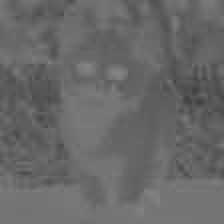

In [24]:
cb

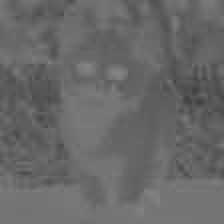

In [25]:
out_img_cb

In [26]:
print(cb == out_img_cb)
print(cr == out_img_cr)

True
True


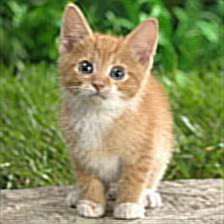

In [27]:
# y, cb, cr 채널들을 모두 합친 후 RGB로 변환
# 400epoch, lr=0.01에서 100epoch마다 1/10씩 감소, batch_size=64, 훈련 데이터 200장
# 최종 PSNR: 24.3322 dB (400epoch)

out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
out_img

## Overall Code

In [28]:
import torch
from PIL import Image
from torchvision.transforms import ToTensor

import numpy as np
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size = 9, stride = 1, padding = 4),
                nn.ReLU())
        
        self.layer2 = nn.Sequential(
                nn.Conv2d(64, 32, kernel_size = 1, stride = 1, padding = 0),
                nn.ReLU())
        
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 1, kernel_size = 5, stride = 1, padding = 2))
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        return x

input_image = 'cat.jpg'

img = Image.open(input_image).convert('YCbCr')
y, cb, cr = img.split()

model = SRCNN()
model.load_state_dict(torch.load('epoch_test.pth'))
img_to_tensor = ToTensor()
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]) # SR 알고리즘은 y채널에만 적용한다

out = model(input)

out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
                                                      
out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')

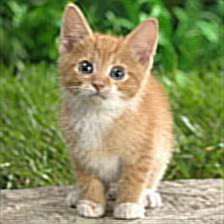

In [29]:
out_img